In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import plotly.graph_objects as go
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import os
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm


In [2]:
path = "attributes.csv"

In [3]:
df = pd.read_csv(path)

In [4]:
attribute_names = df.drop(columns=["X", "Y"]).columns.values
attribute_names

array(['Elev', 'V0', 'fact_ampl_pp_gr', 'fact_ampl_pp_mk',
       'fact_ampl_pp_si', 'fact_ampl_pv_gr', 'fact_ampl_pv_mk',
       'fact_ampl_pv_si', 'fact_freq_pp_gr', 'fact_freq_pp_mk',
       'fact_freq_pp_si', 'fact_freq_pv_gr', 'fact_freq_pv_mk',
       'fact_freq_pv_si'], dtype=object)

Фильтруем нормализуем

In [5]:
def filtered(df,attribute_names,n=3):
    for i in attribute_names:
        mean = df[i].mean()
        sigma = df[i].std()
        df = df[(df[i] <= mean+(n*sigma)) & (df[i] >= mean-(n*sigma))]
    return df

df_filtred = filtered(df, attribute_names, 3)

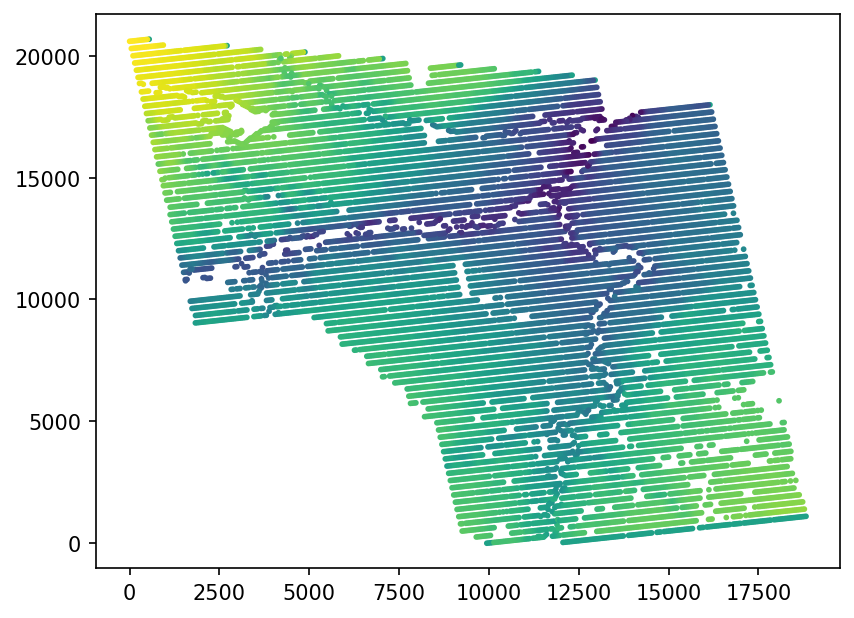

In [6]:
fig = plt.figure(dpi=150)
plt.scatter(df_filtred.X, df_filtred.Y, c=df_filtred.Elev, s=3)

In [7]:
attribute = df_filtred.drop(["X", "Y"], axis=1)
attribute

,Elev,V0,fact_ampl_pp_gr,fact_ampl_pp_mk,fact_ampl_pp_si,fact_ampl_pv_gr,fact_ampl_pv_mk,fact_ampl_pv_si,fact_freq_pp_gr,fact_freq_pp_mk,fact_freq_pp_si,fact_freq_pv_gr,fact_freq_pv_mk,fact_freq_pv_si
0,120.196317,1.384615,284.222090,1.263407,128.907331,273.690278,0.831353,204.348703,8.548696,6.568408,11.996490,10.265258,6.544156,14.080112
1,107.691602,1.384615,121.116506,0.474654,5.883812,226.122562,0.888885,216.866621,6.720315,1.564980,15.489440,11.086243,5.267542,14.642377
2,107.542895,1.384615,129.088820,0.439749,16.006177,251.086520,0.857030,218.860654,6.991201,1.617356,15.545039,12.472042,4.513891,14.664633
3,107.394356,1.285714,138.807711,0.391217,25.677526,260.215629,0.755396,205.086313,7.164131,1.653167,15.596579,13.653929,4.532095,14.609539
4,107.262991,1.285714,149.339632,0.327025,33.080279,250.405839,0.789063,203.922969,7.172312,1.667173,15.658531,11.179142,4.813766,14.357159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17030,129.026108,1.285714,317.425464,0.152284,202.846024,353.228761,3.100431,202.658948,7.404256,8.382143,10.859132,7.452836,9.737535,14.573579
17033,128.980472,1.285714,321.147816,0.056914,202.725123,498.227756,3.545130,301.669270,6.837927,8.773449,10.800875,9.690722,8.176975,13.267308
17041,126.919114,0.696429,263.354696,0.294337,9.028008,51.572902,1.429354,109.946778,1.566024,1.775867,9.069239,12.614860,10.079869,15.106354
17044,126.404079,1.218750,205.526961,0.042533,20.983285,253.511410,0.269825,212.383686,5.371321,2.155317,6.088115,9.588601,8.847043,15.906009


In [8]:
from sklearn.preprocessing import StandardScaler
df_norm = pd.DataFrame(StandardScaler().fit_transform(attribute), columns = attribute.columns)

In [9]:
df_norm

,Elev,V0,fact_ampl_pp_gr,fact_ampl_pp_mk,fact_ampl_pp_si,fact_ampl_pv_gr,fact_ampl_pv_mk,fact_ampl_pv_si,fact_freq_pp_gr,fact_freq_pp_mk,fact_freq_pp_si,fact_freq_pv_gr,fact_freq_pv_mk,fact_freq_pv_si
0,0.202570,1.101212,0.001355,0.028823,0.012318,-0.196837,-0.657137,0.758946,0.131842,0.107547,0.090369,0.524956,-0.533079,-0.576164
1,-1.382969,1.101212,-1.239673,-0.630084,-2.028505,-0.593435,-0.616849,0.995242,-0.497598,-1.535877,1.417192,0.846605,-0.948977,-0.271997
2,-1.401825,1.101212,-1.179014,-0.659242,-1.860587,-0.385297,-0.639157,1.032882,-0.404343,-1.518674,1.438311,1.389538,-1.194503,-0.259957
3,-1.420659,0.526681,-1.105065,-0.699785,-1.700150,-0.309183,-0.710328,0.772870,-0.344810,-1.506911,1.457890,1.852583,-1.188573,-0.289761
4,-1.437315,0.526681,-1.024930,-0.753409,-1.577346,-0.390972,-0.686752,0.750910,-0.341993,-1.502311,1.481422,0.883001,-1.096809,-0.426290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15196,1.322146,0.526681,0.253991,-0.899384,1.238879,0.466318,0.931838,0.727050,-0.262144,0.703285,-0.341665,-0.576906,0.507267,-0.309215
15197,1.316359,0.526681,0.282314,-0.979054,1.236874,1.675254,1.243249,2.596027,-0.457109,0.831814,-0.363794,0.299862,-0.001135,-1.015865
15198,1.054989,-2.896564,-0.157419,-0.780716,-1.976347,-2.048751,-0.238373,-1.023040,-2.272021,-1.466609,-1.021569,1.445492,0.618794,-0.021001
15199,0.989685,0.137676,-0.597416,-0.991068,-1.778022,-0.365079,-1.050361,0.910619,-0.962005,-1.341975,-2.153971,0.259853,0.217161,0.411587


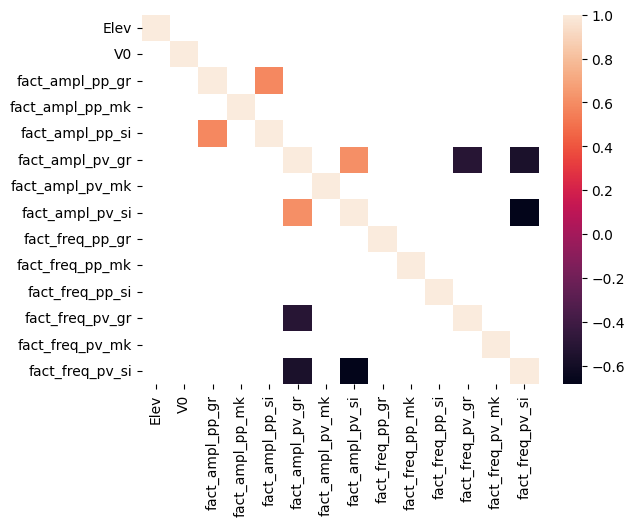

In [10]:
corr_matrix=df_norm.corr()
sns.heatmap(corr_matrix[corr_matrix.abs()>0.5]);

In [11]:
mask = corr_matrix.abs() > 0.5
for i in range(len(corr_matrix)):
  mask.iloc[i,i]=False
mask = mask.any()
mask

Elev               False
V0                 False
fact_ampl_pp_gr     True
fact_ampl_pp_mk    False
fact_ampl_pp_si     True
fact_ampl_pv_gr     True
fact_ampl_pv_mk    False
fact_ampl_pv_si     True
fact_freq_pp_gr    False
fact_freq_pp_mk    False
fact_freq_pp_si    False
fact_freq_pv_gr     True
fact_freq_pv_mk    False
fact_freq_pv_si     True
dtype: bool

In [12]:
X = df_norm.loc[:, ~mask].values
Y = df_norm.loc[:, mask].values
print(X.shape, Y.shape)

(15201, 8) (15201, 6)


In [13]:
class DatasetCustomAtributes(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X_sample = self.X[idx]
        y_sample = self.y[idx]
        sample = {'X': torch.from_numpy(X_sample.astype(np.float32)),
                  'y': torch.from_numpy(y_sample.astype(np.float32))}


        return sample

In [14]:
data = DatasetCustomAtributes(X,Y)

arr_index = np.arange(df_norm.shape[0])
train_data, _, indices_train, indices_test = train_test_split(data, arr_index, test_size=0.1, random_state = 100)
train_data, val_data = train_test_split(train_data, test_size=0.02, random_state = 100)

In [15]:
batch_size = 20
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [16]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(in_features=8, out_features=100),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(in_features=100, out_features=50),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=50, out_features=6))

    def forward(self, input):
        return self.model(input)

In [17]:
num_epochs = 60

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FCNN()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.02)
criterion = nn.L1Loss()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.6)

In [18]:
hist_train = np.zeros(num_epochs)
hist_val = np.zeros(num_epochs)

In [19]:
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for data in train_loader:
        x_batch, y_batch = data["X"].to(device), data["y"].to(device)
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    valid_loss = 0.0
    model.eval()

    for data in val_loader:
        x_batch, y_batch = data["X"].to(device), data["y"].to(device)
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        valid_loss = loss.item() * val_loader.batch_size


    print(f'Epoch {epoch+1} \t Training Loss: {(train_loss / len(train_loader)):.5f}\
                            \t Validation Loss: {(valid_loss / len(val_loader)):.5f}')

    hist_train[epoch] = train_loss/ len(train_loader)
    hist_val[epoch] = valid_loss / len(val_loader)
    scheduler.step()

    if hist_val[epoch] < hist_val[epoch - 1]:
        torch.save(model.state_dict(), "best_model.pth")

Epoch 1 	 Training Loss: 0.77488                            	 Validation Loss: 0.95356
Epoch 2 	 Training Loss: 0.73957                            	 Validation Loss: 0.90391
Epoch 3 	 Training Loss: 0.73000                            	 Validation Loss: 0.89365
Epoch 4 	 Training Loss: 0.72234                            	 Validation Loss: 0.89493
Epoch 5 	 Training Loss: 0.71818                            	 Validation Loss: 0.89478
Epoch 6 	 Training Loss: 0.71625                            	 Validation Loss: 0.89191
Epoch 7 	 Training Loss: 0.71435                            	 Validation Loss: 0.88862
Epoch 8 	 Training Loss: 0.71142                            	 Validation Loss: 0.88759
Epoch 9 	 Training Loss: 0.70844                            	 Validation Loss: 0.88248
Epoch 10 	 Training Loss: 0.70802                            	 Validation Loss: 0.87977
Epoch 11 	 Training Loss: 0.70721                            	 Validation Loss: 0.87620
Epoch 12 	 Training Loss: 0.70717        

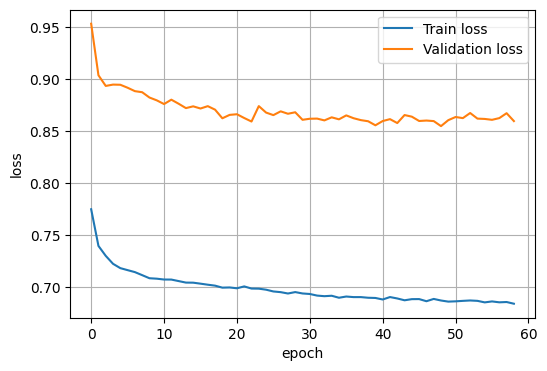

In [20]:
fig = plt.figure(figsize=(6, 4))

plt.plot(hist_train[:epoch], label="Train loss")
plt.plot(hist_val[:epoch], label="Validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()

In [21]:
model.eval()
model.load_state_dict(torch.load("best_model.pth"))
result = model(torch.from_numpy(X[indices_test].astype(np.float32))).detach().numpy()

In [22]:
std = attribute.std(axis=0)
mean = attribute.mean(axis=0)


std_target = std[mask]
mean_target = mean[mask]


In [24]:
prediction = np.zeros_like(result)
real = np.zeros_like(result)
for i in range(len(std_target)-1):
    prediction[:, i] = result[:, i] * std_target[i] + mean_target[i]
    real[:, i] = Y[indices_test][:,i] * std_target[i] + mean_target[i]

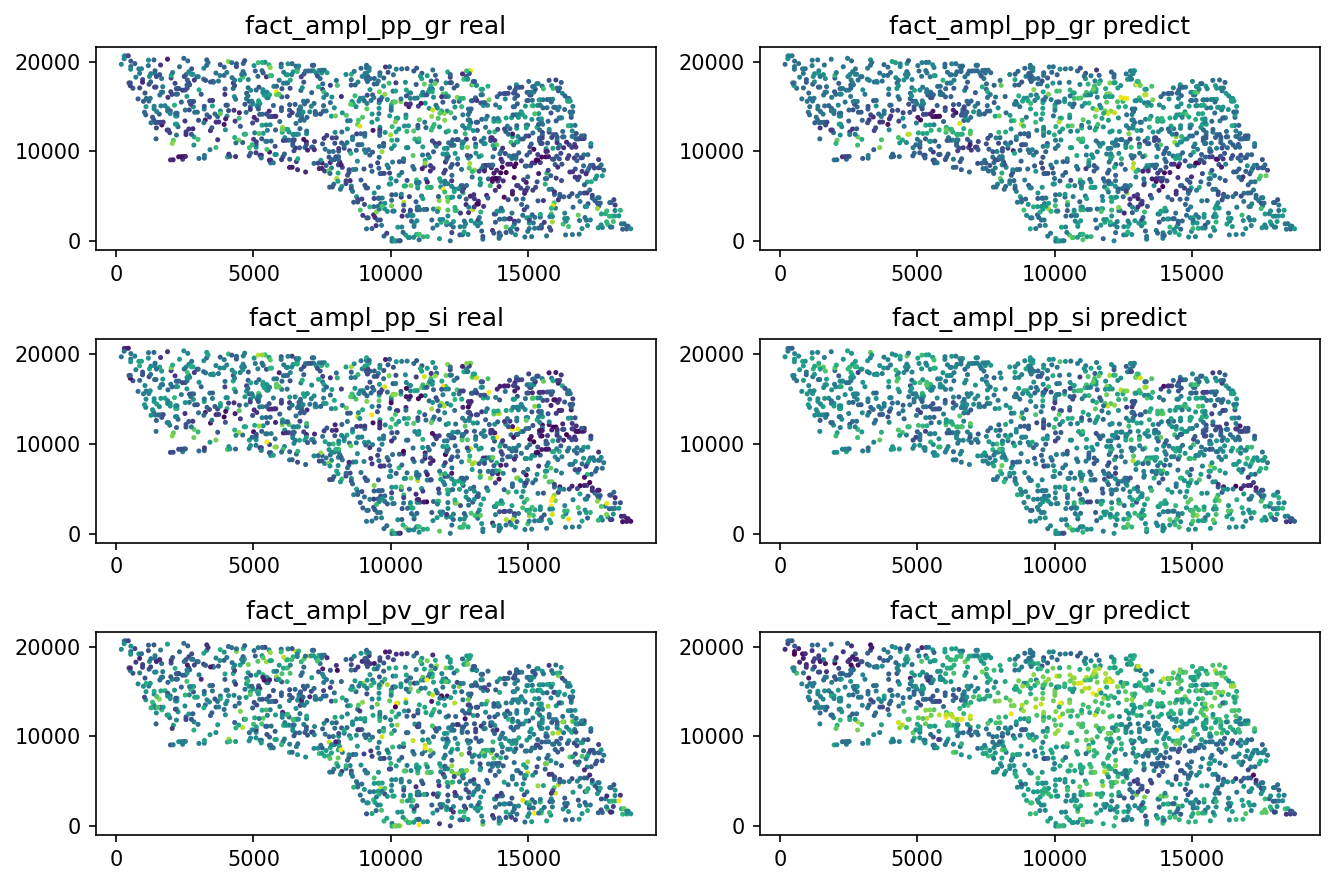

In [26]:
attributes = df_norm.keys()[mask]
X = df_filtred.X.values
Y = df_filtred.Y.values

fig, ax = plt.subplots(3, 2, figsize=(9, 6), dpi=150)

for i in range(3):
  ax[i, 0].scatter(X[indices_test], Y[indices_test], c=real[:, i], s=2)
  ax[i, 0].set_title(attributes[i] + " real");
  ax[i, 1].scatter(X[indices_test], Y[indices_test], c=prediction[:, i], s=2)
  ax[i, 1].set_title(attributes[i]+ " predict");


fig.tight_layout()

In [27]:
!pip install torchmetrics

In [28]:
from torchmetrics.regression import MeanAbsolutePercentageError, MeanAbsoluteError, MeanSquaredError, KLDivergence

In [29]:
mape = torch.zeros(3)
mae = torch.zeros(3)
mse = torch.zeros(3)
kld = torch.zeros(3)

for i in range(3):
    mape[i] = MeanAbsolutePercentageError()(torch.from_numpy(real[:, i]), torch.from_numpy(prediction[:,i]))
    mae[i] = MeanAbsoluteError()(torch.from_numpy(real[:, i]), torch.from_numpy(prediction[:,i]))
    mse[i] = MeanSquaredError()(torch.from_numpy(real[:, i]), torch.from_numpy(prediction[:,i]))
    kld[i] = KLDivergence()(torch.from_numpy(real[:, i]).reshape(1, -1), torch.from_numpy(prediction[:,i]).reshape(1, -1))


In [30]:
mape, mae, mse, kld

(tensor([0.2942, 0.3030, 0.3093]),
 tensor([76.7595, 35.0481, 88.6616]),
 tensor([10116.9756,  2107.8196, 12739.0020]),
 tensor([0.0648, 0.0703, 0.0742]))